In [60]:
# install optuna if not
try:
    import optuna
    print('optuna ver.:', optuna.__version__)
except:
    !pip install optuna

optuna ver.: 3.5.0


In [61]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from IPython.display import display

# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

## Загрузка и подготовка данных

**✔Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [62]:
df = pd.read_csv('Advertising.csv')

**✔Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [63]:
def df_info(df: pd.DataFrame):
    """
    Displays comprehensive information about the pandas DataFrame including
    the number of records, columns, explicit duplicates, missing values,
    unique values, descriptive statistics, and a preview of the first 3 rows.

    Parameters:
    df (pd.DataFrame): The DataFrame to be analyzed.
    """
    len_df = len(df)
    na_columns = df.isna().sum()
    missing_value_columns = na_columns[na_columns > 0]
    unique_counts = df.nunique()

    # General Information
    print(f'Number of records:\t {len_df}')
    print(f'Number of columns:\t {len(df.columns)}')
    print(f'Explicit duplicates:\t {df.duplicated().sum()}')

    # Missing Values Information
    print(f'Missing values present in {len(missing_value_columns)} columns out of {len(df.columns)}:')
    missing_percentage = (missing_value_columns / len_df * 100).sort_values(ascending=False)
    if any(missing_percentage):
        display(pd.DataFrame({'Missing Count': missing_value_columns, 'Missing %': missing_percentage}))

    # Unique Values Information
    print('Number of unique values in each feature:')
    display(pd.DataFrame({'Unique Values': unique_counts}).sort_values(by='Unique Values', ascending=False))

    # Descriptive Statistics
    print('\nStatistics:')
    display(df.describe(include='all'))

    # Summary Information
    print('\nSummary information:')
    df.info(verbose=True)  # Removed null_counts parameter

    # Preview of the First 3 Rows
    print('\nFirst 3 rows:')
    display(df.head(3))

# Example usage:
# df = pd.read_csv('your-dataset.csv')
df_info(df)

Number of records:	 200
Number of columns:	 5
Explicit duplicates:	 0
Missing values present in 0 columns out of 5:
Number of unique values in each feature:


,Unique Values
Unnamed: 0,200
TV,190
newspaper,172
radio,167
sales,121



Statistics:


,Unnamed: 0,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000



Summary information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   radio       200 non-null    float64
 3   newspaper   200 non-null    float64
 4   sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB

First 3 rows:


,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3


### Вывод по разделу
Пропуски не обнаружены

**✔Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [64]:
# Создание матрицы наблюдений X
X = df.drop(['sales', 'Unnamed: 0'], axis=1).values

# Вектор правильных ответов —  y
y = df['sales'].values

# check
X[:3], y[:3]


(array([[230.1,  37.8,  69.2],
        [ 44.5,  39.3,  45.1],
        [ 17.2,  45.9,  69.3]]),
 array([22.1, 10.4,  9.3]))

## Координатный спуск (3 балла)

**✔Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [65]:
# import numpy as np
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

# check
X[:3]

array([[  1. , 230.1,  37.8,  69.2],
       [  1. ,  44.5,  39.3,  45.1],
       [  1. ,  17.2,  45.9,  69.3]])

**✔Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [66]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

# check
X[:3]
# Normalization is done by dividing each element in a column 
# by the square root of the sum of squares of all elements in that column.

array([[0.07071068, 0.09561706, 0.09692057, 0.13052034],
       [0.07071068, 0.01849178, 0.10076663, 0.08506456],
       [0.07071068, 0.00714739, 0.11768927, 0.13070895]])

**✔Реализуйте алгоритм координатного спуска:** (3 балла)

✔Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [67]:
def fit_linear_model(X, y, num_iters=1000, precision=1e-9):
    """
    Fits a linear model using a custom iterative algorithm - coordinate descent, limiting the loss function's
    precision during the calculations and reports the number of iterations taken to reach the specified precision.
    
    Parameters:
    X (numpy.ndarray): The input features matrix with shape (m, n).
    y (numpy.ndarray): The target vector with shape (m,).
    num_iters (int): The number of iterations to run the algorithm.
    precision (float): The desired precision of the cost function.

    Returns:
    tuple: A tuple containing the cost after the final iteration, the weights vector w, and the number of iterations performed.
    """
    m, n = X.shape  # m: number of rows, n: number of columns in matrix X
    w = np.zeros(n)  # initialize weights vector of size n with zeros
    iteration_count = 0  # initialize iteration counter

    for i in range(num_iters):
        for k in range(n):
            # Compute the prediction without the k-th factor
            h = (X[:, 0:k] @ w[0:k]) + (X[:, k+1:] @ w[k+1:])
            # Update the new value of the k-th coefficient
            w[k] = (X[:, k].T @ (y - h))
        
        # Compute the cost function
        cost = sum((X @ w) - y) ** 2/(len(y))
        
        # If the cost is already at the desired precision, break the loop
        if cost < precision:
            iteration_count = i + 1  # update the iteration counter to the current iteration
            break
    
    # If we didn't break out of the loop, we hit the maximum number of iterations
    if iteration_count == 0:
        iteration_count = num_iters
    
    return precision, cost, w, iteration_count

# Example usage:
# Assuming X and y are defined and are numpy arrays


precision, cost, w, iterations = fit_linear_model(X, y)
print(f'Заданная точность: {precision}')
print(f'Значение функции потерь: {cost}')
print(f'Количество итераций: {iterations}')
print(f'Вектор весов: {w}')

Заданная точность: 1e-09
Значение функции потерь: 6.94871852736473e-10
Количество итераций: 54
Вектор весов: [ 41.56224451 110.13144649  73.5286098   -0.55012919]


✔Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [68]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
 
print(model.coef_)

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


In [69]:
# Евклидово расстояние между векторами предсказаний координатным спуском и линейной регрессией sklearn
np.linalg.norm(w - model.coef_)

9.776206764029564e-05

Если вы все сделали верно, они должны практически совпасть!

### Вывод по разделу
Тысяча итераций в общем то и не нужна. Точность у коэффициентов до 3 знака после запятой всего при 50 итерациях достигается.


## Стохастический градиентный спуск (6 баллов)

**✔Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [70]:
# Переопределяем матрицу наблюдений 
X = df.drop(['sales', 'Unnamed: 0'], axis=1).values

In [71]:
# Ensure X is not a single value and has variance to avoid division by zero
if X.size > 1 and X.std() != 0:
    # Perform Z-score normalization (масштабирование с помощью Z-оценки)
    X = (X - X.mean()) / X.std()
    print("Масштабирование проведено корректно. Первые три элемента:\n", X[:3])
else:
    print("Масштабирование невозможно. X содержит только одно значениe или нет вариаций значений.")

Масштабирование проведено корректно. Первые три элемента:
 [[ 2.12559023 -0.37983282  0.02926902]
 [-0.29254039 -0.36028974 -0.28472315]
 [-0.64822447 -0.27430018  0.03057189]]


**✔Добавим единичный столбец**

In [72]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

#check
X[:3]

array([[ 1.        ,  2.12559023, -0.37983282,  0.02926902],
       [ 1.        , -0.29254039, -0.36028974, -0.28472315],
       [ 1.        , -0.64822447, -0.27430018,  0.03057189]])

**✔Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [73]:
def mse_error(y, y_pred):
    """
    Calculate the mean squared error between the true values and predicted values.

    Parameters:
    y (array_like): True values. Must be 1D array or similar structure.
    y_pred (array_like): Predicted values. Must be 1D array of the same length as y.

    Returns:
    float: Mean squared error of the predictions.
    """
    return ((y - y_pred) ** 2).mean()    

**✔Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [74]:
# Наивный прогноз таргета
y_pred = np.full(len(y), y.mean())

# check
y_pred[:3]

array([14.0225, 14.0225, 14.0225])

In [75]:
# MSE для наивного прогноза
mse_error(y, y_pred)

27.085743750000002

**✔Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [76]:
def lin_pred(X, w):
    """
    Compute the vector of predictions from the predictor matrix and weight vector.

    Parameters:
    X (array_like): Predictor matrix where each row corresponds to an observation 
                    and each column corresponds to a feature.
    w (array_like): Weight vector for the linear model.

    Returns:
    array_like: Vector of predictions for each observation.
    """
    return np.dot(X, w)

**✔Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [77]:
def stoch_grad_step(X, y, w, train_ind, eta):
    """
    Perform a single stochastic gradient descent step based on mean squared error loss.

    Parameters:
    X (array_like): Matrix of features with shape (n_samples, n_features).
    y (array_like): Vector of target variable with shape (n_samples,).
    w (array_like): Current weights vector with shape (n_features,).
    train_ind (int): Index of the training sample to use for this step.
    eta (float): Learning rate.

    Returns:
    array_like: Updated weights vector with shape (n_features,).

    Note:
    The function assumes that the loss function used is mean squared error (MSE)
    and that a separate function `lin_pred` is available for making predictions.
    """
    x_i = X[train_ind]  # Select the training sample
    y_i = y[train_ind]  # Select the corresponding target value
    
    # Compute the prediction for the selected instance
    y_pred_i = lin_pred(x_i.reshape(1, -1), w)
    
    # Calculate the gradient direction for the selected instance
    grad_direction = (x_i * 2 * (y_pred_i - y_i)) / len(X)
    
    # Update the weights vector in the direction opposite to the gradient
    new_w = w - eta * grad_direction

    return new_w

**✔Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [78]:
def stochastic_gradient_descent(X, y, init_weights, learn_rate, max_iter, min_eucl_dist):
    """
    Performs stochastic gradient descent optimization to find the optimal weights for a linear model.

    Args:
        X (numpy.ndarray): The input features matrix with shape (m_samples, n_features).
        y (numpy.ndarray): The target vector with shape (m_samples,).
        init_weights (numpy.ndarray): The initial weights vector with shape (n_features,).
        learn_rate (float): The learning rate for the optimization algorithm.
        max_iter (int): The maximum number of iterations to perform.
        min_eucl_dist (float): The minimum Euclidean distance between consecutive weight updates.

    Returns:
        tuple: A tuple containing the final weights vector and a list of mean squared errors for each iteration.
    """
    weight_dist = np.inf  # Initialize the weight distance to infinity for the first comparison
    errors = []  # List to store mean squared errors for each iteration
    cnt = 0  # Counter to keep track of the number of iterations

    # Loop until the weight updates are smaller than the min_eucl_dist or the max_iter is reached
    while weight_dist > min_eucl_dist and cnt < max_iter:
        train_ind = np.random.randint(X.shape[0])  # Randomly select an index for the training sample

        # Perform a stochastic gradient descent step and get new weights
        new_weights = stoch_grad_step(X, y, init_weights, train_ind, learn_rate)
        
        # Calculate the Euclidean distance between the new weights and the previous weights
        weight_dist = np.linalg.norm(new_weights - init_weights)
        
        # Update the weights for the next iteration
        init_weights = new_weights

        # Calculate the mean squared error for the current weights and add it to the errors list
        y_pred = lin_pred(X, init_weights)  # Predict the target values using the current weights
        errors.append(mse_error(y, y_pred))  # Compute the MSE and append to errors list
        
        cnt += 1  # Increment the iteration counter

    # Once the loop is finished, return the final weights and the errors list
    return init_weights, errors

 **✔Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

**✔Постройте график зависимости ошибки от номера итерации**

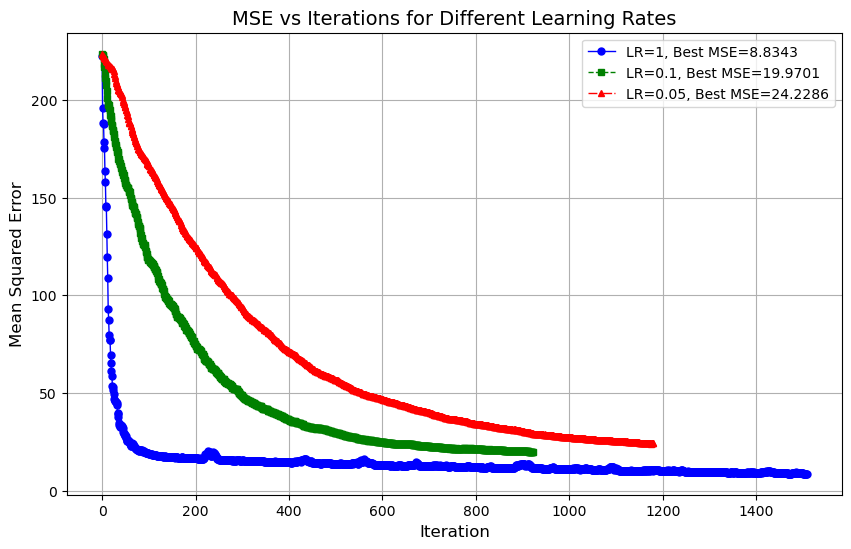

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X, y and stochastic_gradient_descent function are already defined

m, n = X.shape  # m: number of rows, n: number of columns in matrix X
init_weights = np.zeros(n)  # initialize weights vector of size n with zeros
learning_rates = [1, 0.1, 0.05]  # The list of learning rates to compare
max_iter = 10**5
min_eucl_dist = 10**(-5)

# Initialize plot
plt.figure(figsize=(10, 6))  # 10x6 inches for the figure size

# Custom styles for each learning rate
line_styles = ['-', '--', '-.']
markers = ['o', 's', '^']
colors = ['b', 'g', 'r']

# Plot MSE for each learning rate with enhanced styles and best MSE labels
for learn_rate, line_style, marker, color in zip(learning_rates, line_styles, markers, colors):
    final_weights, errors = stochastic_gradient_descent(X, y, init_weights, learn_rate, max_iter, min_eucl_dist)
    best_mse = errors[-1]  # Assuming errors is a list where the last item is the final MSE
    plt.plot(errors, label=f'LR={learn_rate}, Best MSE={best_mse:.4f}', linestyle=line_style, marker=marker, color=color, linewidth=1, markersize=5)

plt.title('MSE vs Iterations for Different Learning Rates', fontsize=14, fontweight='normal')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.legend()  # Add a legend to distinguish between different learning rates
plt.grid(True)  # Add grid for better readability
plt.show()

In [80]:
m, n = X.shape  # m: number of rows, n: number of columns in matrix X
init_weights = np.zeros(n)  # initialize weights vector of size n with zeros
learn_rate = 1  # 
max_iter = 10**5
min_eucl_dist = 10**(-5)
final_weights, errors = stochastic_gradient_descent(X, y, init_weights, learn_rate, max_iter, min_eucl_dist)

**Выведите вектор весов, к которому сошелся метод.**

In [81]:
print(f'вектор весов, к которому сошелся метод: {final_weights}')

вектор весов, к которому сошелся метод: [14.42417737  3.98723177  6.6669418   1.01347405]


**Выведите среднеквадратичную ошибку на последней итерации.**

In [82]:
print(f'MSE на последней итерации: {errors[-1]}')

MSE на последней итерации: 5.110744223664408


### БОНУСНОЕ ЗАДАНИЕ

Разумеется, в реальности специалисты по машинному обучению не прописывают алгоритмы с нуля, а пользуются готовыми реализациями из библиотек. Реализованный Вами стохастический градиентный спуск представлен в библиотеке sklearn.

Что необходимо сделать:

Выберите в документации класс, подходящий для вашей задачи, и обучите стохастический градиентный спуск.
Оцените качество с помощью среднеквадратичной ошибки и сравните результат с результатом алгоритма, реализованного вами самостоятельно.
В одном из предыдущих модулей качество решения задачи регрессии оценивалось с помощью ещё одной метрики. Найдите её реализацию в библиотеке sklearn и оцените качество полученной модели.
Данное задание не является обязательным, но, выполнив его, вы получите возможность заработать дополнительные 3 балла.

In [83]:
# Импортируем необходимые библиотеки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

# Подготавливаем данные
# Удаляем столбцы 'sales' и 'Unnamed: 0', которые не будут использоваться в качестве признаков
X = df.drop(['sales', 'Unnamed: 0'], axis=1)
# Столбец 'sales' будет использоваться в качестве целевой переменной
y = df['sales']

# Разделяем данные на обучающий и тестовый наборы
# test_size=0.2 означает, что 20% данных будут использоваться для тестирования, остальные для обучения
# random_state=42 используется для воспроизводимости разделения
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализируем StandardScaler для масштабирования признаков
scaler = StandardScaler()
# Обучаем scaler на обучающем наборе и преобразуем обучающий набор
X_train_scaled = scaler.fit_transform(X_train)
# Преобразуем тестовый набор с использованием уже обученного scaler
X_test_scaled = scaler.transform(X_test)

# Создаем экземпляр SGDRegressor
# Конструктор SGDRegressor принимает различные параметры, которые можно настроить
sgd_regressor = SGDRegressor(random_state=42)
# Обучаем модель на масштабированных обучающих данных
sgd_regressor.fit(X_train_scaled, y_train)

# Теперь модель готова к использованию для предсказания на тестовых данных или в продакшене
# Например, можно оценить качество модели на тестовых данных
from sklearn.metrics import mean_squared_error

y_pred = sgd_regressor.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка (MSE) на тестовых данных: {mse}')

Среднеквадратичная ошибка (MSE) на тестовых данных: 3.1822269355145694


In [28]:
from sklearn.metrics import mean_squared_error, r2_score

# Получаем веса признаков и свободный член (интерсепт)
weights = sgd_regressor.coef_
intercept = sgd_regressor.intercept_

# Выводим коэффициенты модели
print("Веса признаков:", weights)
print("Свободный член:", intercept)

# Вычисляем и выводим значение функции потерь на обучающих данных
# SGDRegressor использует квадратичную функцию потерь по умолчанию, поэтому это будет MSE
mse_train = mean_squared_error(y_train, sgd_regressor.predict(X_train_scaled))
print("Среднеквадратичная ошибка (MSE) на обучающих данных:", mse_train)

# Вычисляем и выводим количество итераций
n_iter = sgd_regressor.n_iter_
print("Количество итераций:", n_iter)

# Вычисляем и выводим метрику R^2
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2)

Веса признаков: [3.75776408 2.77777167 0.06871719]
Свободный член: [14.07812304]
Среднеквадратичная ошибка (MSE) на обучающих данных: 2.7058862142858424
Количество итераций: 25
Коэффициент детерминации (R^2): 0.8991804621260984


In [27]:
sgd_regressor.coef_

array([3.75776408, 2.77777167, 0.06871719])

In [25]:
X = df.drop(['sales', 'Unnamed: 0'], axis=1)
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    # Define the hyperparameters to tune via Optuna
    max_iter = trial.suggest_int('max_iter', 100, 10000)
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)  # Updated method here
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)  # Assuming this was updated earlier
    
    # Create an instance of the SGDRegressor with the current hyperparameters
    sgd_reg = SGDRegressor(
        penalty='elasticnet',
        max_iter=max_iter,
        tol=tol,
        l1_ratio=l1_ratio,
        random_state=42,
    )
    
    # Fit the SGDRegressor to the scaled training data
    sgd_reg.fit(X_train_scaled, y_train)
    
    # Make predictions on the scaled testing data
    y_pred = sgd_reg.predict(X_test_scaled)
    
    # Calculate MSE on test data
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Create a study object and specify the direction is 'minimize'.
study = optuna.create_study(direction='minimize')

# Optimize the study, the objective function is passed in as the first argument.
study.optimize(objective, n_trials=50)  # You can specify the number of trials

# Extract the best estimator
best_params = study.best_params
best_sgd_reg = SGDRegressor(
    penalty='elasticnet',
    max_iter=best_params['max_iter'],
    tol=best_params['tol'],
    l1_ratio=best_params['l1_ratio'],
    random_state=42,
)
best_sgd_reg.fit(X_train_scaled, y_train)

# Make predictions with the best parameters
y_pred = best_sgd_reg.predict(X_test_scaled)

# Calculate MSE and MAE on test data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE on test data: {mse}")
print(f"MAE on test data: {mae}")

# Print best hyperparameters
print("Best hyperparameters:", best_params)

[I 2023-12-23 10:35:05,092] A new study created in memory with name: no-name-d87304b5-2aee-4a4f-a205-cd99d28a3066
[I 2023-12-23 10:35:05,103] Trial 0 finished with value: 3.199792943032013 and parameters: {'max_iter': 9077, 'tol': 0.007551311129413331, 'l1_ratio': 0.22029126680515684}. Best is trial 0 with value: 3.199792943032013.
[I 2023-12-23 10:35:05,108] Trial 1 finished with value: 3.18884179816542 and parameters: {'max_iter': 4523, 'tol': 0.0017717713448275989, 'l1_ratio': 0.5989233877201177}. Best is trial 1 with value: 3.18884179816542.
[I 2023-12-23 10:35:05,118] Trial 2 finished with value: 3.1711102868743457 and parameters: {'max_iter': 4360, 'tol': 0.00016541398230755384, 'l1_ratio': 0.3631274140033912}. Best is trial 2 with value: 3.1711102868743457.
[I 2023-12-23 10:35:05,131] Trial 3 finished with value: 3.198833211983918 and parameters: {'max_iter': 8900, 'tol': 0.014815926137570372, 'l1_ratio': 0.537095719797603}. Best is trial 2 with value: 3.1711102868743457.
[I 202

[I 2023-12-23 10:35:06,021] Trial 39 finished with value: 3.17102678135284 and parameters: {'max_iter': 5043, 'tol': 0.00018053829084919556, 'l1_ratio': 0.6328545683601836}. Best is trial 32 with value: 3.170956504095551.
[I 2023-12-23 10:35:06,062] Trial 40 finished with value: 3.18043977359492 and parameters: {'max_iter': 1923, 'tol': 0.0005227426132665749, 'l1_ratio': 0.2452106194420947}. Best is trial 32 with value: 3.170956504095551.
[I 2023-12-23 10:35:06,102] Trial 41 finished with value: 3.1709727169843234 and parameters: {'max_iter': 1559, 'tol': 0.00037577565811130234, 'l1_ratio': 0.8075148762888843}. Best is trial 32 with value: 3.170956504095551.
[I 2023-12-23 10:35:06,182] Trial 42 finished with value: 3.1709572306147122 and parameters: {'max_iter': 645, 'tol': 0.00024456565061067566, 'l1_ratio': 0.8575494190808525}. Best is trial 32 with value: 3.170956504095551.
[I 2023-12-23 10:35:06,224] Trial 43 finished with value: 3.1723148164497905 and parameters: {'max_iter': 643,

MSE on test data: 3.170956504095551
MAE on test data: 1.4621712181033442
Best hyperparameters: {'max_iter': 758, 'tol': 0.00033690410292441434, 'l1_ratio': 0.8598967594855244}


### Вывод и сравнение методов

Подбор гиперпараметров и использование `SGDRegressor` могут дать лучшие результаты по сравнению с самописной функцией стохастического градиентного спуска (SGD) по нескольким причинам:

Оптимизация гиперпараметров: `SGDRegressor` из библиотеки `scikit-learn` позволяет настраивать множество гиперпараметров (например, скорость обучения, регуляризацию, размер мини-батча и т.д.), что может значительно улучшить производительность модели. В то время как в самописной функции параметры часто задаются статически и требуют ручной настройки.

`Эффективность реализации`: `SGDRegressor` оптимизирован для высокой производительности на больших наборах данных и может автоматически использовать оптимизации, такие как векторизация и многопоточность.

`Регуляризация`: В `SGDRegressor` включены различные виды регуляризации (L1, L2, ElasticNet), которые помогают контролировать переобучение модели, в то время как в самописном коде их нужно реализовывать отдельно.

`Устойчивость к численным ошибкам`: `SGDRegressor` реализует механизмы для предотвращения численных ошибок (например, оптимизацию скорости обучения), что может быть не рассмотрено в самописной реализации.

`Обработка больших данных`: `SGDRegressor` более эффективно работает с большими объемами данных благодаря частичному обучению, при котором данные подаются в модель порциями.

Интерпретации `SGDRegressor` через MAE (Mean Absolute Error) и MSE (Mean Squared Error):

`MAE (Mean Absolute Error)`: Это средняя абсолютная ошибка между предсказанными и истинными значениями. Она менее чувствительна к выбросам и дает более стабильную оценку производительности модели, но не подчеркивает большие ошибки.

`MSE (Mean Squared Error)`: Это средняя квадратичная ошибка. Она более чувствительна к выбросам, так как штрафует за большие ошибки сильнее, чем за малые. Это может быть полезно в задачах, где важно избегать больших ошибок.

`SGDRegressor` поддерживает различные функции потерь, включая squared_loss (которая соответствует MSE) и epsilon_insensitive (которая при настройке параметров может приближаться к MAE). Выбор функции потерь зависит от конкретной задачи и желаемой чувствительности к выбросам. При использовании SGDRegressor, можно интерпретировать его эффективность, анализируя значения MAE и MSE следующим образом:

MAE дает представление о среднем абсолютном отклонении предсказаний от истинных значений. Низкое значение MAE указывает на то, что в среднем предсказания модели близки к фактическим значениям, что хорошо для многих практических приложений. Однако, MAE может не полностью отражать качество модели, если в данных присутствуют выбросы.

MSE дает представление о среднем квадрате ошибок предсказаний. Поскольку ошибки возводятся в квадрат перед усреднением, большие ошибки имеют более весомый вклад в конечный результат. Это делает MSE полезной метрикой, когда важно штрафовать модель за большие ошибки. Низкое значение MSE указывает на то, что модель не только предсказывает точные значения в среднем, но и избегает больших ошибок, что может быть критически важно в некоторых задачах.

Выбор между MAE и MSE зависит от конкретной задачи и от того, насколько серьезно нужно относиться к большим ошибкам по сравнению с маленькими. Некоторые задачи могут требовать использования других метрик, таких как RMSE (корень из среднеквадратичной ошибки), которая представляет собой корень из MSE и имеет те же единицы измерения, что и исходные данные.

SGDRegressor в scikit-learn позволяет легко вычислить MAE и MSE с помощью функций `mean_absolute_error` и `mean_squared_error` соответственно.